# Исследование пользователей сервиса аренды самокатов GoFast
Необходимо проанализировать данные о пользователях сервиса аренды самокатов GoFast, а также об их поездках из нескольких городов и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти:
- тратят ли пользователи с подпиской больше времени на поездки;
- можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Основные блоки в проекте:
- загрузка данных;
- предобработка данных;
- исследовательский анализ данных;
- объединение данных;
- подсчет выручки;
- проверка гипотез;
- распределения;
- общий вывод.

## Загрузка данных

Для начала импортируем все необходимые в прокте библиотеки:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
from scipy.stats import norm

Загрузим данные о пользователях, поездках и подписках:

In [2]:
#Считываем данные о пользователях, поездках и подписках и сохраняем в переменные users, rides и subscriptions соответственно
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
#Выводим первые 5 строк датафреймов
display(users.head(5), rides.head(5), subscriptions)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Посмотрим информацию о датафреймах `users` и `rides` с помощью метода `info()`

In [3]:
users.info()
print()
rides.info()
print()
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   C

Видно, что все данные есть (пустых строк нет), у некоторых столбцов необходимо заменить тип.

Посмотрим на матрицу диаграмм рассеяния датафрейма `rides`:

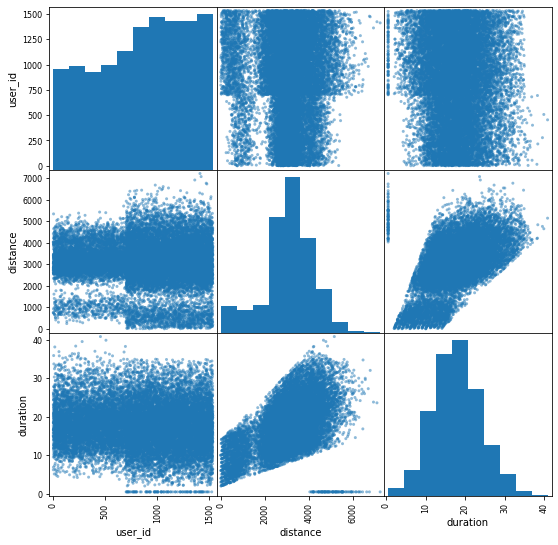

In [4]:
pd.plotting.scatter_matrix(rides, figsize=(9, 9))
plt.show()

По матрице видно, что:
- есть очень длинные дистанции при почти нулевой продолжительности поездки и это наблюдается только у пользователей с user_id больше 650. 

## Предобработка данных

### Замена типов данных

Заменим тип данных:

In [5]:
# заменим тип данных столбцов user_id, name, city и subscription_type в переменной users на category
users[['user_id', 'name', 'city', 'subscription_type']] = \
users[['user_id', 'name', 'city', 'subscription_type']].astype('category')
# заменим тип данных столбца user_id в переменной rides на category
rides['user_id'] = rides['user_id'].astype('category')
# заменим тип данных столбца date в переменной rides на datetime64
rides['date'] = rides['date'].astype('datetime64')
# заменим тип данных столбца subscription_type в переменной subscriptions на category
subscriptions['subscription_type'] = subscriptions['subscription_type'].astype('category')

### Обработка дубликатов

Проверим есть ли в датафреймах `users` и `rides` дубликаты:

In [6]:
print(f"""
Количество дубликатов в users: {users.duplicated().sum()}
Количество дубликатов в rides: {rides.duplicated().sum()}
"""
)


Количество дубликатов в users: 31
Количество дубликатов в rides: 0



Удалим дубликаты в `users`:

In [7]:
# удаляем дубликаты с помощью метода .drop_duplicates и обновим индексы методом .reset_index
users = users.drop_duplicates().reset_index(drop=True)

### Обработка аномальных значений

Посмотрим, что за строки с малой продолжительностью, но большим расстоянием поездки:

In [8]:
# отсортируем rides по столбцу duration по возрастанию и выведем первые 10 строк
rides.sort_values(by='duration').head(10)

,user_id,distance,duration,date
12013,1102,4602.122401,0.5,2021-08-01
17314,1483,4445.481070,0.5,2021-03-06
15029,1318,5894.633314,0.5,2021-03-28
7437,766,4539.088310,0.5,2021-12-22
12967,1172,4907.140751,0.5,2021-12-19
15015,1317,4593.389022,0.5,2021-07-16
13012,1176,4935.071045,0.5,2021-05-14
7508,772,4718.820996,0.5,2021-05-22
16589,1428,5059.187375,0.5,2021-05-06
9049,890,4848.485014,0.5,2021-11-20


Интересно: продолжительность поездки 0.5 минут, а расстояния больше 4000 метров (получается скорость их была более 500 км/ч), не порядок, видимо произошла ошибка при выгрузке данных, посчитаем сколько таких строк:

In [9]:
# посчитаем количество строк с duration равным 0.5
len(rides.loc[rides['duration'] == 0.5])

95

Получилось 95 строк имеют некорректные данные, это всего 0,5% от всего датафрейма, поэтому удалим эти строки, чтобы они не повлияли на дальнейший анализ и посмотрим на диграмму рассеяния после удаления:

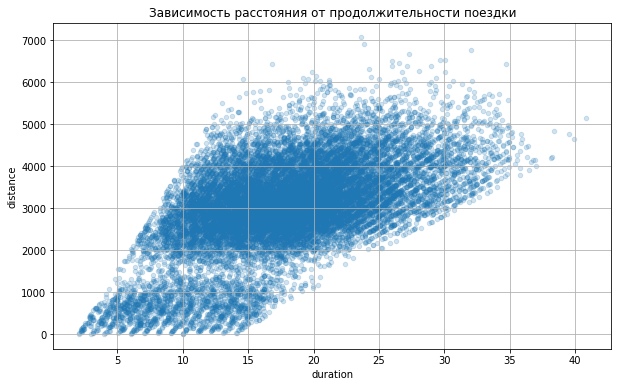

In [10]:
# с помощью метода .query срежем строки, где, duration меньше 0.5
rides = rides.query('duration > 0.5').reset_index(drop=True)
rides.plot(
        x='duration', # значения оси Х
        y='distance', # значения оси У
        kind='scatter', # тип графика scatter
        alpha=0.2, # прозрачность точек
        title='Зависимость расстояния от продолжительности поездки', #название графика
        figsize=(10, 6), # размер графика
        grid=True, # сетка
    )
plt.show()

По диаграмме рассеяния видно, что аномалии в районе нулевой длительности ушли.

### Добавление столбцов

Для дальнейшего анализа понадобится месяц поездки, добавим столбец `month` в датасет `rides`:

In [11]:
# Добавляем столбец month, соответствующий месяцу в date
rides['month'] = rides['date'].dt.month

Проверим за сколько лет собраны данные, чтобы если, что учесть это при дальнейшем анализе:

In [12]:
rides['date'].dt.year.unique()

array([2021])

Данные о поездах только за 2021 год - это хорошо.

**Вывод по предобработке данных:**

В данном блоке были:
- заменены типы данных столбцов;
- удалены дубликаты и аномалии;
- добавлены необходимые столбцы.

## Исследовательский анализ данных

Посмотрим пользователи из каких городов есть в датасете `users`:

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64

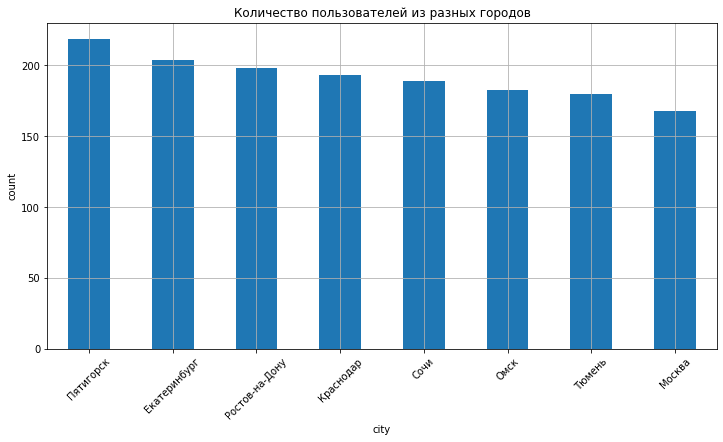

In [13]:
# посчитаем сколько раз встречаюnся разные города 
display(users.value_counts('city'))
(
# построим барплот
users.value_counts('city')
    .plot.bar(
    ylabel='count', # подпись оси У
    figsize=(12,6), # размер графика
    grid=True, # сетка
    rot=45, # поворот подписей оси Х
    title='Количество пользователей из разных городов' # название графика
    )
)
plt.show()

По гистограмме видно, что:
- в данных есть пользователи из 8 разных городов;
- всех больше пользователейй из Пятигорска (219);
- всех меньше - из Москвы (168).

Посмотрим соотношение пользователей с подпиской и без подписки:


Количество пользователей с подпиской: 699
Количество пользователей без подписки: 835



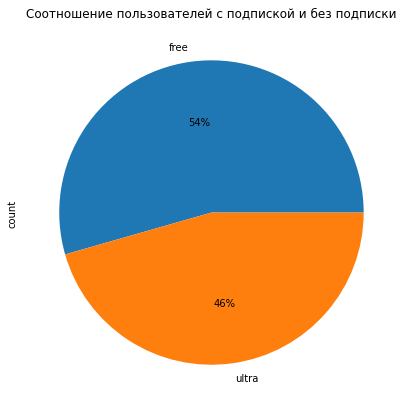

In [14]:
print(f"""
Количество пользователей с подпиской: {len(users.loc[users['subscription_type'] == 'ultra'])}
Количество пользователей без подписки: {len(users.loc[users['subscription_type'] == 'free'])}
""")
(
# посчитаем сколько пользователей с подпиской и без 
users.value_counts('subscription_type')
    .plot(
        kind='pie', # тип графика
        title='Соотношение пользователей с подпиской и без подписки', # название графика
        ylabel='count', # подпись оси
        figsize=(7, 7), # размер графика
        autopct='%1.0f%%' # подписи данных
    )
)
plt.show()

Посмотрим на возраст пользователей с помощью функции `describe()` и постром гистограмму:

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

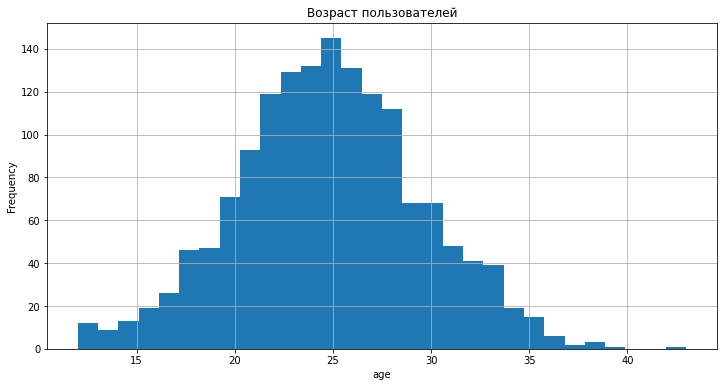

In [15]:
display(users['age'].describe())
# построим гистограмму по столбцу age
users['age'].plot(
    kind='hist', # тип графика
    bins=(len(users['age'].value_counts())+1), # количество корзин 
    figsize=(12,6), # размер графика
    grid=True, # сетка
    title='Возраст пользователей' #название графика
)
plt.xlabel('age')
plt.show()

По описанию и гистограмме видно, что:
- средний возраст и медиана всех возрастов 25 лет;
- распределение возраста пользоватерей - нормальное.

Посмотрим на расстояние, которое пользователь преодолел за одну поездку с помощью функции `describe()` и гистограммы:

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

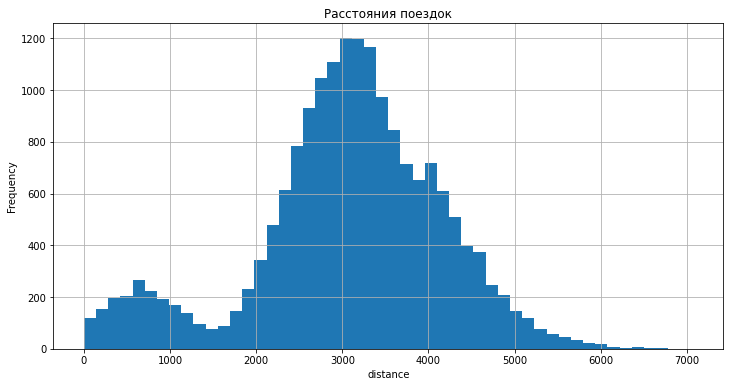

In [16]:
display(rides['distance'].describe())
# построим гистограмму по столбцу distance
rides['distance'].plot(
    kind='hist', # тип графика
    bins=50, # количество корзин 
    figsize=(12,6), # размер графика
    grid=True, # сетка
    title='Расстояния поездок' #название графика
)
plt.xlabel('distance')
plt.show()

По описанию и гистограмме расстояний поездок видно, что:
- средднее расстояние 3060 метров;
- пользователи проезжали от 0,9 метров до 7066 метров;
- есть два ярко выраженных пика на 0,6 км и 3 км.

Посмотрим на длительность поездок с помощью функции `describe()` и постром гистограмму:

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

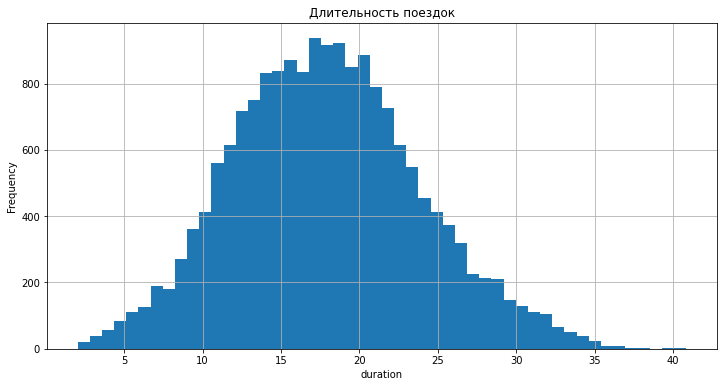

In [17]:
display(rides['duration'].describe())
# построим гистограмму по столбцу duration
rides['duration'].plot(
    kind='hist', # тип графика
    bins=50, # количество корзин 
    figsize=(12,6), # размер графика
    grid=True, # сетка
    title='Длительность поездок' #название графика
)
plt.xlabel('duration')
plt.show()

По гистограмме длительности поездок видно, что распределение длительности поездок похоже на нормальное распределение со средней длительностю позедки 17,9 минут.

**Вывод по блоку анализа данных:**

В данном блоке были отмечено слудующее:
- в датасетах собраны данные по пользователям из 8 городов;
- пользователей с подпиской меньше, чем без подписки;
- возраст пользователей и длительность поездок распределена нормально с пиками 25 лет и 18 минут соответсвенно;
- расстояния поездок имеют ярко выраженные пики: 0,6 км и 3 км.

## Объединение данных

Для дальнейшего анализа и проверки гипотез объединим датафреймы в один `data_full`:

In [18]:
# с помощью метода .merge добавим к rides датафреймы users и subscriptions
data_full = (rides\
    .merge(users, on='user_id', how='left')
    .merge(subscriptions, on='subscription_type', how='left')
)
display(data_full.head(5))
data_full.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  category      
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  category      
 6   age                17973 non-null  int64         
 7   city               17973 non-null  category      
 8   subscription_type  17973 non-null  category      
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(2), int64(5)
memory usage: 1.4 MB


Все данные объединились корректно, количество строк совпадает с исходным датафреймом `rides` (за вычетом удаленных строк), пропусков данных нет.

Создадим еще один датафрейм `data_free` с данными пользователей без подписки: 

In [19]:
# с помощью метода .query выберем строки с пользователями без подписки
data_free = (data_full
             .query('subscription_type == "free"')
             .reset_index(drop=True)
            )
# выведем первые пять строк датафрейма и посмотрим на информацию о нем
display(data_free.head(5))
data_free.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11473 entries, 0 to 11472
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  category      
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int64         
 5   name               11473 non-null  category      
 6   age                11473 non-null  int64         
 7   city               11473 non-null  category      
 8   subscription_type  11473 non-null  category      
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(2), int64(5)
memory usage: 834.7 KB


Создадим еще один датафрейм `data_ultra` с данными пользователей с подпиской:

In [20]:
# с помощью метода .query выберем строки с пользователями с подпиской
data_ultra = (data_full
              .query('subscription_type == "ultra"')
              .reset_index(drop=True)
             )
# выведем первые пять строк датафрейма и посмотрим на информацию о нем
display(data_ultra.head(5))
data_ultra.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   category      
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   category      
 6   age                6500 non-null   int64         
 7   city               6500 non-null   category      
 8   subscription_type  6500 non-null   category      
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: category(4), datetime64[ns](1), float64(2), int64(5)
memory usage: 494.8 KB


Датафрейм `data_ultra` получился в 0.43 раза меньше датафрейма `data_free`.

Посмотрим изменились ли распределения расстояния и длительности поездок пользователей после разделения на пользователей с подпиской и без:

'Сводная статистика по расстоянию поездок пользователей без подписки:'

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

'Сводная статистика по расстоянию поездок пользователей с подпиской:'

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

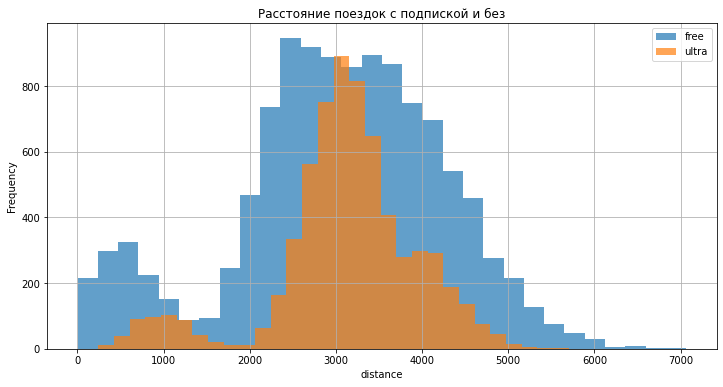

In [21]:
display('Сводная статистика по расстоянию поездок пользователей без подписки:', data_free['distance'].describe())
display('Сводная статистика по расстоянию поездок пользователей с подпиской:', data_ultra['distance'].describe())
ax = data_free.plot(
    kind='hist', # тип графика
    y='distance', # значения оси y
    bins=30, # количество корзин
    alpha=0.7, # прозрачность столбцов
    label='free' # название данных
)
data_ultra.plot(
    kind='hist', # тип графика
    y='distance', # значения оси y
    bins=30, # количество корзин
    alpha=0.7, # прозрачность столбцов
    label='ultra', # название данных
    ax=ax, # объединенине гистограмм
    grid=True, # сетка
    legend=True, # легенда
    figsize=(12,6), # размер графика
    title='Расстояние поездок с подпиской и без' # название графика
)
plt.xlabel('distance')
plt.show()

'Сводная статистика по длительности поездок пользователей без подписки:'

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

'Сводная статистика по длительности поездок пользователей с подпиской:'

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

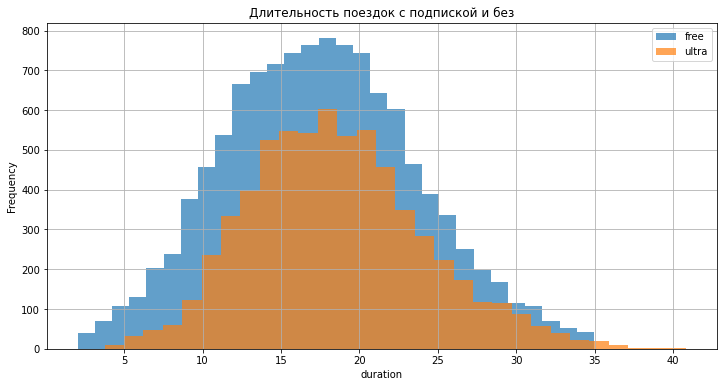

In [22]:
display('Сводная статистика по длительности поездок пользователей без подписки:', data_free['duration'].describe())
display('Сводная статистика по длительности поездок пользователей с подпиской:', data_ultra['duration'].describe())
ax = data_free.plot(
    kind='hist', # тип графика
    y='duration', # значения оси y
    bins=30, # количество корзин
    alpha=0.7, # прозрачность столбцов
    label='free' # название данных
)
data_ultra.plot(
    kind='hist', # тип графика
    y='duration', # значения оси y
    bins=30, # количество корзин
    alpha=0.7, # прозрачность столбцов
    label='ultra', # название данных
    ax=ax, # объединенине гистограмм
    grid=True, # сетка
    legend=True, # легенда
    figsize=(12,6), # размер графика
    title='Длительность поездок с подпиской и без' # название графика
)
plt.xlabel('duration')
plt.show()

По гистограммам видно, что:
- форма распределения расстояния повторяет общую, но первый пик у пользователей с подпиской дальше, чем у пользователей без подписки (1 км против 0,5 км);
- межквартильный размах расстояний пользователей с подпиской меньше, чем у пользователей без подписки (1523 метра против 775 метров), таким образом можно сказать, что у пользователей без подписки больший диапазон расстояний поездок;
- медианное значение расстояния пользователей с подпиской больше: 3148,6 метров против 3102,1 метров у пользователей без подписки;
- форма распределения длительности поездок идентична для пользователей с подпиской и без;
- стандартное отклонение распределения длительности поездки у пользователей с подпиской меньше, таким образом можно сказать, что у пользователей без подписки больший разброс длительности поездок;
- медианное значение длительности поездки пользователей с подпиской больше: 18,2 минуты против 17,4 минут у пользователей без подписки.

## Подсчёт выручки

Необходимо подсчитать выручку с каждого пользователя, но для начала округлим значения длительности поездки `duration` до ближайшего целого:

In [23]:
data_full['duration'] = np.ceil(data_full['duration']).astype('int')

Создадим датафрейм `data_income` с агрегированными данными о поездках на основе `data_full`, где найдем количество поездок `count_trips` и суммарное расстояние `distance_sum` и время `duration_sum` для каждого пользователя за каждый месяц, а также укажем тип подписки:

In [24]:
data_income = (data_full
               # сводим 
               .pivot_table(
                   index=['user_id', 'month', 'subscription_type'],
                   values=['distance', 'duration'],
                   aggfunc={'distance': ('count', 'sum'), 'duration': 'sum'})
               # соединяем мульти названия столбцов в одно название, через _
               .pipe(lambda x: x.set_axis(map('_'.join, x), axis=1))
               # переименовываем столбец distance_count в количество поездок count_trips
               .rename(columns = {'distance_count':'count_trips'})
               )
# убираем строки с нулевым значением поездок, и сбрасываем индексы
data_income = data_income.loc[data_income['count_trips'] != 0].reset_index()
# выводим первые 10 строк датафрейма
display(data_income.head(5))
data_income.info()

,user_id,month,subscription_type,count_trips,distance_sum,duration_sum
0,1,1,ultra,2,7027.511294,42
1,1,4,ultra,1,754.159807,7
2,1,8,ultra,2,6723.470560,46
3,1,10,ultra,2,5809.911100,32
4,1,11,ultra,3,7003.499363,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   user_id            11300 non-null  category
 1   month              11300 non-null  int64   
 2   subscription_type  11300 non-null  category
 3   count_trips        11300 non-null  int64   
 4   distance_sum       11300 non-null  float64 
 5   duration_sum       11300 non-null  int64   
dtypes: category(2), float64(1), int64(3)
memory usage: 430.8 KB


Получился датафрейм с 11300 строками без пропусков.

Теперь добавим столбец `income`, где с помощью функции посчитаем месячную выручку по формуле:

<div align="center">
  (start_ride_price * count_trips) + (minute_price * duration_sum) + subscription_fee,
</div>

где 
- `start_ride_price` - стоимость старта поездки;
- `count_trips` - количество поездок;
- `minute_price` - стоимость одной минуты поездки;
- `duration_sum` - общая продолжительность всех поездок в минутах;
- `subscription_fee` - стоимость подписки.

In [25]:
# создаем функцию income для подсчета выручки за месяц для отдельных пользователей
def income(row):
    if row['subscription_type'] == 'free':
        return (subscriptions.loc[0, 'start_ride_price'] * row['count_trips'] \
                + subscriptions.loc[0, 'minute_price'] * row['duration_sum'])
    else:
        return (subscriptions.loc[1, 'start_ride_price'] * row['count_trips'] \
                + subscriptions.loc[1, 'minute_price'] * row['duration_sum'] \
                + subscriptions.loc[1, 'subscription_fee'])
# добавляем столбец income в датафрейм data_income
data_income['income'] = data_income.apply(income, axis=1)
# выводим первые 10 строк датафрейма
data_income.head(5)

,user_id,month,subscription_type,count_trips,distance_sum,duration_sum,income
0,1,1,ultra,2,7027.511294,42,451
1,1,4,ultra,1,754.159807,7,241
2,1,8,ultra,2,6723.470560,46,475
3,1,10,ultra,2,5809.911100,32,391
4,1,11,ultra,3,7003.499363,56,535


В данном блоке была подсчитана выручка за месяц по отдельным пользователям

## Проверка гипотез

### Проверка первой гипотезы

Необходимо проверить гипотезу: тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

**Нулевая гипотеза:** среднее время поездки пользователей с подпиской равно среднему времени поездки пользователя без подписки

**Альтернативная гипотеза:** среднее время поездки пользователей с подпиской больше среднего времени поездки пользователя без подписки

Чтобы проверить эту гипотезу, необходимо сравнить среднее двух генеральных совокупностей, поэтому воспользуемся методом `.ttest_ind`:

In [26]:
# задаём уровень значимости 5%
alpha = 0.05 
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше», 
# так как выборки разные по размеру используем equal_var=False
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False,  alternative='greater')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.6162210195311063e-29
Отвергаем нулевую гипотезу


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. 

**Первая гипотеза подтвердилась:** есть основания говорить, что среднее время поездки пользователей с подпиской больше среднего времени поездки пользователя без подписки.

### Проверка второй гипотезы

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Необходимо проверить гипотезу: можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Нулевая гипотеза:** среднее расстояние поездки пользователей с подпиской равно 3130 метров

**Альтернативная гипотеза:** среднее расстояние поездки пользователей с подпиской больше 3130 метров

Чтобы проверить эту гипотезу, необходимо сравнить среднее генеральной совокупности с числом, поэтому воспользуемся методом `.ttest_1sample`:

In [27]:
# оптимальное расстояние
optimal_distance = 3130
# уровень статистической значимости 5%
alpha = 0.05
# проводим ttest для одной выборки, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_1samp(data_ultra['distance'], optimal_distance, alternative='greater')
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу


Полученное значение p-value больше уровня статистической значимости, поэтому нельзя отвергнуть нулевую теорию.

**Вторая гипотеза не подтвердилась:** после проверки нельзя утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, поэтому можно сказать, что расстояние поездов является оптимальнм с точки зрения износа самоката.

### Проверка третей гипотезы

Необходимо проверить гипотезу: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Нулевая гипотеза:** помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки

**Альтернативная гипотеза:** помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки

Чтобы проверить эту гипотезу, необходимо сравнить среднее двух генеральных совокупностей, поэтому воспользуемся методом `.ttest_ind`:

In [28]:
# задаём уровень значимости 5%
alpha = 0.05 
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data_income.query('subscription_type == "ultra"')['income'],
                       data_income.query('subscription_type == "free"')['income'], 
                       alternative='greater'
                      )
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. 

**Третья гипотеза подтвердилась:** есть основания говорить, что месячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Вопрос

**Вопрос:** Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:** Так как выборки зависимы, для проверки гипотезы необходимо воспользоваться методом `scipy.stats.ttest_rel()`, которому нужно передать парные выборки до и после изменения и указать `alternative='less'`,чтобы применить левосторонюю альтернативную гипотезу о том, что количество обращений до изменения больше, чем количество обращений после изменения.

## Распределения

### Задача №1

Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. 

**Задача:** выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. 

Для решения задачи необходимо апроксимировать биномиальное распределение нормальным, чтобы определить вероятность того, что меньше 100 пользователей продлили подписку с помощью метода `.cdf`. После нескольких попыток удалось подобрать оптимальное количество промокодов, которое необходимо для того, чтобы вероятность не выполнить план была примерно 5%:

In [29]:
n = 1168 # количество промокодов 
p = 0.1 # вероятность продления подписки

mu = n * p # мат. ожидание для нормального распределения
sigma = (n * p * (1 - p))**0.5 # стандартное отклонение для нормального распределения

distr = st.norm(mu, sigma)  # задаем нормальное распределение параметрами mu и sigma

result = distr.cdf(100) # вероятность того, что меньше 100 пользователей продлили подписку

print('Вероятность того, что меньше 100 пользователей продлили подписку:', "{:.0%}".format(result))

Вероятность того, что меньше 100 пользователей продлили подписку: 5%


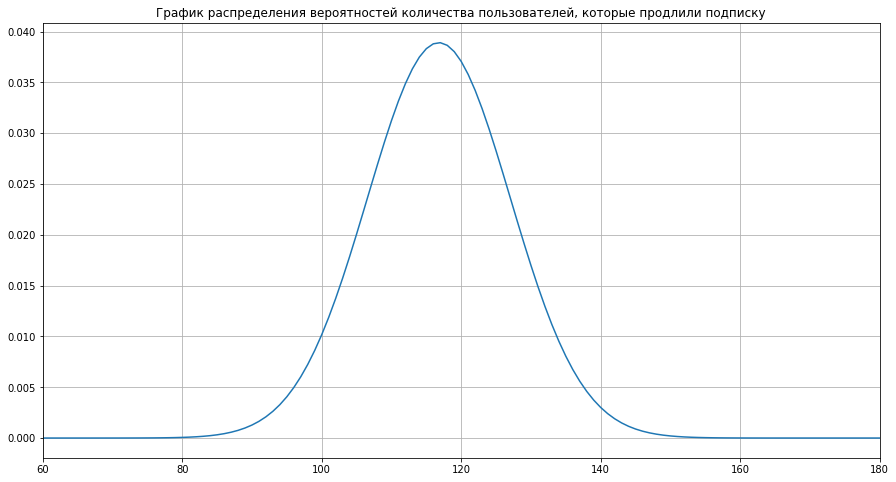

In [30]:
x_axis = np.arange(0, 1168) # список чисел от 0 до 1168
    
n = 1168 # количество промокодов
p = 0.1 # вероятность продления подписки

mu = n * p # мат. ожидание для нормального распределения
sigma = (n * p * (1 - p))**0.5 # стандартное отклонение для нормального распределения

plt.figure(figsize=(15, 8)) # размер графика
plt.title('График распределения вероятностей количества пользователей, которые продлили подписку') # название графика
plt.grid(b=True) # сетка
plt.xlim(60, 180) # ограничения по оси Х
plt.plot(x_axis, norm.pdf(x_axis, mu, sigma))  # график
plt.show()

Необходимо разослать 1168 промокодов для того, чтобы вероятность того что менее 100 пользователй продлят подписку была примерно 5%, это видно и по гистограмме (площадь столбцов левее 100 пользователй примерно равня 0,05).

### Задача №2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. 

**Задача:** С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. 

Для решения задачи необходимо апроксимировать биномиальное распределение нормальным, чтобы с помощью метода `.cdf` определить вероятность того, что не более 399,5 пользователей откроют уведомление:

In [31]:
n = 1000000 # количество push-уведомлений
p = 0.4 # вероятность открытия push-уведомления

mu = n * p # мат. ожидание для нормального распределения
sigma = (n * p * (1 - p))**0.5 # стандартное отклонение для нормального распределения

distr = st.norm(mu, sigma)  # задаем нормальное распределение параметрами mu и sigma

result = distr.cdf(399500) # вероятность того, что уведомление откроют не более 399,5 тыс. пользователей

print('Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:', "{:.2%}".format(result))

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.37%


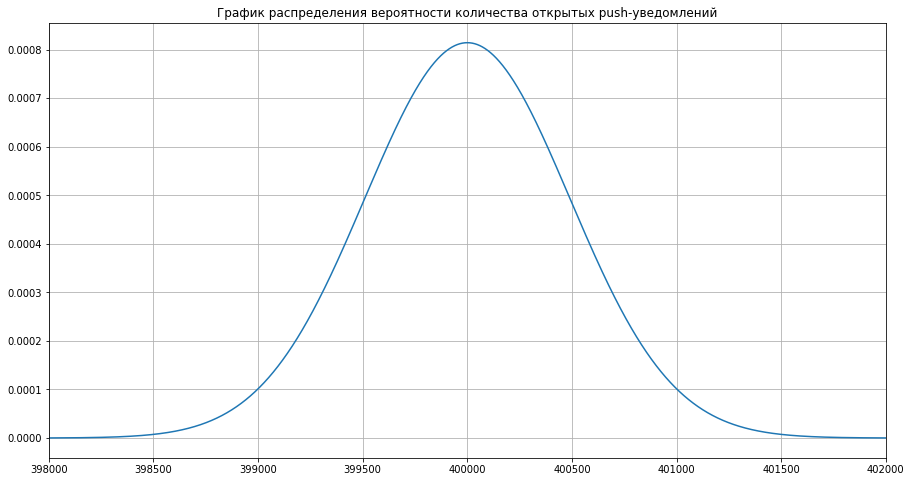

In [32]:
x_axis = np.arange(0, 1000000) # список чисел от 0 до 1000000
    
n = 1000000 # количество push-уведомлений
p = 0.4 # вероятность открытия push-уведомления

mu = n * p # мат. ожидание для нормального распределения
sigma = (n * p * (1 - p))**0.5 # стандартное отклонение для нормального распределения

plt.figure(figsize=(15, 8)) # размер графика
plt.title('График распределения вероятности количества открытых push-уведомлений') # название графика
plt.grid(b=True) # сетка
plt.xlim(398000, 402000) # ограничения по оси Х
plt.plot(x_axis, norm.pdf(x_axis, mu, sigma))  # график
plt.show()

Вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей равно 15.37%, что и видно на графике.

## Общий вывод

В проекте "Исследование пользователей сервиса аренды самокатов GoFast" проделана работа по изучению данных и их предобработке, а именно были:
- заменены типы данных некоторых столбцов;
- удалены дубликаты и аномалии;
- добавлены необходимые для дальнейшего исследования столбцы.

Затем данные были проанализированны и выявлено что:
- в датасетах собраны данные по пользователям из 8 городов;
- пользователей с подпиской меньше, чем без подписки;
- возраст пользователей и длительность поездок распределена нормально с пиками 25 лет и 18 минут соответсвенно;
- расстояния поездок имеют ярко выраженные пики: 0,6 км и 3 км.

Потом все данные были сведены в один датасет и разделены на два разных датасета с подписчиками и без, после чего выявилось, что:
- форма распределения расстояния повторяет общую, но первый пик у пользователей с подпиской дальше, чем у пользователей без подписки (1 км против 0,5 км);
- форма распределения длительности поездок идентична для пользователей с подпиской и без.

Также была рассчитана выручка от каждого пользователя по месяцам.

Было проверено три гипотезы, две из которых подтвердились:
- среднее время поездки пользователей с подпиской больше среднего времени поездки пользователя без подписки;
- месячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки;

и одна не подтвердилась:
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Еще было решено две задачи в ходе решения которых выяснено, что:
- необходимо разослать 1168 промокодов для того, чтобы вероятность не выполнить план в 100 пользователй продливших подписку была примерно 5% (при вероятности продления подписки 10%);
- вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей равно 15.37% (при 40% вероятности открытия push-уведомления и рассылке 1 млн. уведомлений).